## Combined Notebook: Plane Delays & Calculations

After the data cleaning process done in , let's go ahead with the analysis!

### CRISP-DM Framework

* Business Problem: 
* Data Understanding: What the data set is
* Data Preparation: All Data Cleaning, inc treatment of missing Data, NaNs, zeros, transforms
* Modelling: The Modelling Workflow, models used and feature transforms / engineering
* Evaulation: Evaluation of the Final Model vs Baseline Model
* Deployment: Results generated by the model

### CRISP-DM Framework: Business Problem:
* Identify Factors that could help Reduce Flight Cancellations / Delays for intenal US departing from Wisconsin.
* Save money / stress, etc.

### What the data set is:

The U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics tracks the on-time performance of domestic flights operated by large air carriers. Summary information on the number of on-time, delayed, canceled, and diverted flights is published in DOT's monthly Air Travel Consumer Report and in this dataset of 2015 flight delays and cancellations.

The dataset was sourced from Kaggle.

https://www.kaggle.com/usdot/flight-delays

In [2]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (30,30)
%matplotlib inline

import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
import scipy.stats as stats

import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from statsmodels.graphics.gofplots import qqplot

from statsmodels.stats.outliers_influence import variance_inflation_factor

from yellowbrick.regressor import ResidualsPlot

## Importing `.csv`

In [4]:
df = pd.read_csv('wisconsin.csv')
df.head(2)
df.drop(df.columns[0], axis=1, inplace=True)

In [5]:
# all years are 2015
del df['YEAR']

In [6]:
df.head(1)

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,airline_full_name,ORIGIN_CITY,ORIGIN_STATE,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,DESTINATION_CITY,DESTINATION_STATE,DESTINATION_LATITUDE,DESTINATION_LONGITUDE
0,7,1,3,OO,3423,N170SY,MKE,SEA,1605,1603.0,-2.0,11.0,1614.0,260.0,254.0,231.0,1694,1805.0,12.0,1825,1817.0,-8.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Skywest Airlines Inc.,Milwaukee,WI,42.94722,-87.89658,Seattle,WA,47.44898,-122.30931


In [7]:
df.columns

Index(['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'airline_full_name',
       'ORIGIN_CITY', 'ORIGIN_STATE', 'ORIGIN_LATITUDE', 'ORIGIN_LONGITUDE',
       'DESTINATION_CITY', 'DESTINATION_STATE', 'DESTINATION_LATITUDE',
       'DESTINATION_LONGITUDE'],
      dtype='object')

In [8]:
df['CANCELLATION_REASON'] = df['CANCELLATION_REASON'].replace('nan', np.nan).fillna(0)
df['AIR_SYSTEM_DELAY'] = df['AIR_SYSTEM_DELAY'].replace('nan', np.nan).fillna(0)
df['SECURITY_DELAY'] = df['SECURITY_DELAY'].replace('nan', np.nan).fillna(0)
df['AIRLINE_DELAY'] = df['AIRLINE_DELAY'].replace('nan', np.nan).fillna(0)
df['LATE_AIRCRAFT_DELAY'] = df['LATE_AIRCRAFT_DELAY'].replace('nan', np.nan).fillna(0)
df['WEATHER_DELAY'] = df['WEATHER_DELAY'].replace('nan', np.nan).fillna(0)
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].replace('nan', np.nan).fillna(0)
df['DEPARTURE_DELAY'] = df['DEPARTURE_DELAY'].replace('nan', np.nan).fillna(0)
df['TAXI_OUT'] = df['TAXI_OUT'].replace('nan', np.nan).fillna(0)
df['WHEELS_OFF'] = df['WHEELS_OFF'].replace('nan', np.nan).fillna(0)
df['ELAPSED_TIME'] = df['ELAPSED_TIME'].replace('nan', np.nan).fillna(0)
df['AIR_TIME'] = df['AIR_TIME'].replace('nan', np.nan).fillna(0)
df['WHEELS_ON'] = df['WHEELS_ON'].replace('nan', np.nan).fillna(0)
df['TAXI_IN'] = df['TAXI_IN'].replace('nan', np.nan).fillna(0)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].replace('nan', np.nan).fillna(0)
df['ARRIVAL_DELAY'] = df['ARRIVAL_DELAY'].replace('nan', np.nan).fillna(0)

In [9]:
# Can change the threshold of delayed here to 5 min, 10 min, 20 min, 30 min etc.
df['DELAYED_TARGET'] = np.where(df['DEPARTURE_DELAY'] > 0, 1, 0)

In [10]:
df.head(2)
df.columns

Index(['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'airline_full_name',
       'ORIGIN_CITY', 'ORIGIN_STATE', 'ORIGIN_LATITUDE', 'ORIGIN_LONGITUDE',
       'DESTINATION_CITY', 'DESTINATION_STATE', 'DESTINATION_LATITUDE',
       'DESTINATION_LONGITUDE', 'DELAYED_TARGET'],
      dtype='object')

# Dataset exploration

## Visual exploration

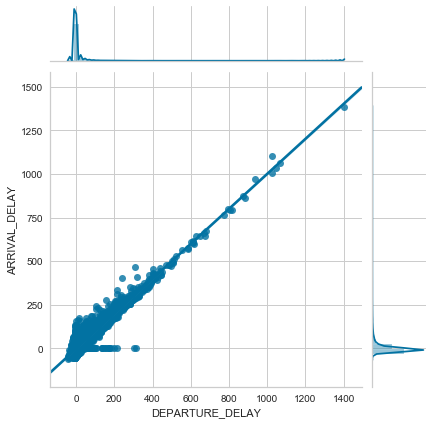

In [11]:
sns.jointplot('DEPARTURE_DELAY','ARRIVAL_DELAY', data=df, kind='reg');

# Feature selection

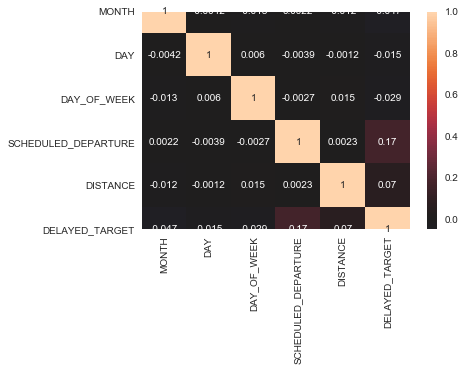

In [14]:
features = ['MONTH',                    
            'DAY',                      
            'DAY_OF_WEEK',                 
            'SCHEDULED_DEPARTURE',            
            'DISTANCE',
            'DELAYED_TARGET',
            ]

#'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
 #      'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
  #     'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
   #    'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
    #   'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
     #  'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
      # 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       #'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'airline_full_name',
#       'ORIGIN_CITY', 'ORIGIN_STATE', 'ORIGIN_LATITUDE', 'ORIGIN_LONGITUDE',
 #      'DESTINATION_CITY', 'DESTINATION_STATE', 'DESTINATION_LATITUDE',
  #     'DESTINATION_LONGITUDE'

target = df['DEPARTURE_DELAY']
dff = df[features].copy()
sns.heatmap(dff.corr(), center=0, annot=True);

### Class Imbalance

In [20]:
import pandas as pd
import numpy as np
import itertools

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE, ADASYN

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [21]:
df['DELAYED_TARGET'].value_counts()

0    37545
1    13831
Name: DELAYED_TARGET, dtype: int64

In [22]:
y = df['DELAYED_TARGET']
X = dff.drop(columns=['DELAYED_TARGET'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [23]:
# Training set
print(y_train.value_counts())
print('\n')
# Test set
print(y_test.value_counts())

0    28159
1    10373
Name: DELAYED_TARGET, dtype: int64


0    9386
1    3458
Name: DELAYED_TARGET, dtype: int64


### Logistic Regression Model : Baseline Model

AUC: 0.5785862883289622


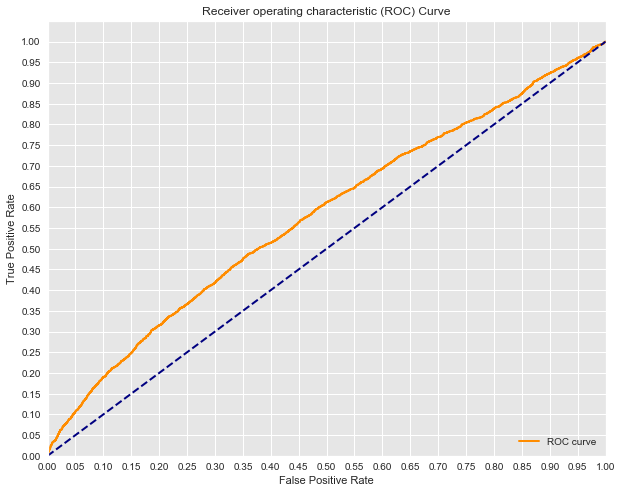

In [30]:
# Initial Model
logreg = LogisticRegression(fit_intercept=False, solver='liblinear')

# Probability scores for test set
y_score = logreg.fit(X_train, y_train).decision_function(X_test)
# False positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Print AUC
print('AUC: {}'.format(auc(fpr, tpr)))

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [31]:
# Plot a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #Add Normalization Option
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[9320 3368]
 [  66   90]]


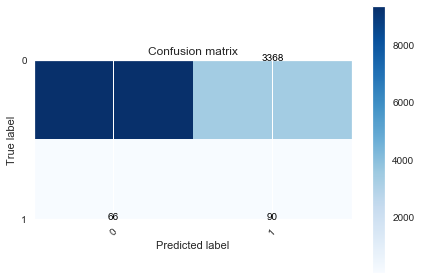

In [32]:
# Plot confusion matrix of the test set 
y_hat_test = logreg.predict(X_test)
cnf_matrix = confusion_matrix(y_hat_test, y_test)
plot_confusion_matrix(cnf_matrix, classes=[0, 1])

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.001: 0.5780029280777876
-------------------------------------------------------
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.01: 0.5785299364804675
-------------------------------------------------------
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
         

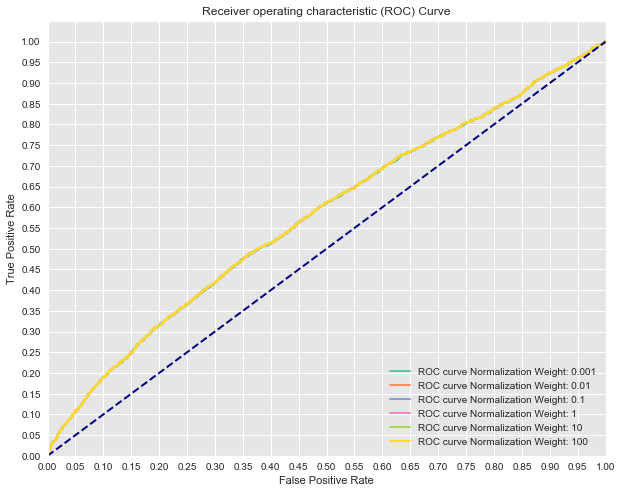

In [33]:
# Now let's compare a few different regularization performances on the dataset:
C_param_range = [0.001, 0.01, 0.1, 1, 10, 100]
names = [0.001, 0.01, 0.1, 1, 10, 100]
colors = sns.color_palette('Set2')

plt.figure(figsize=(10, 8))

for n, c in enumerate(C_param_range):
    # Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='liblinear')
    model_log = logreg.fit(X_train, y_train)
    print(model_log) # Preview model params

    # Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train, y_train).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------')
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Normalization Weight: {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### SMOTE

In [34]:
# Use the SMOTE class from the imblearn package in order to improve the model's performance on the minority class.

# Previous original class distribution
print(y_train.value_counts()) 

# Fit SMOTE to training data
X_train_resampled, y_train_resampled = SMOTE().fit_sample(X_train, y_train) 

# Preview synthetic sample class distribution
print('\n')
print(pd.Series(y_train_resampled).value_counts()) 

0    28159
1    10373
Name: DELAYED_TARGET, dtype: int64


1    28159
0    28159
Name: DELAYED_TARGET, dtype: int64


LogisticRegression(C=0.005, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.005: 0.6218320032160914
-------------------------------------------------------
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.1: 0.6218068929063467
-------------------------------------------------------
LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
           

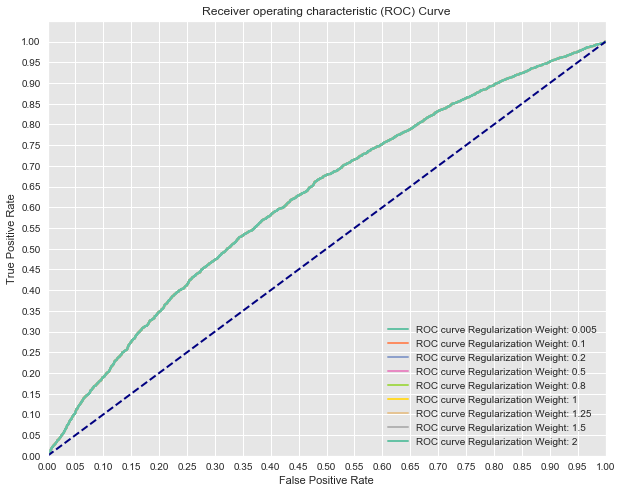

In [35]:
# Now let's compare a few different regularization performances on the dataset
C_param_range = [0.005, 0.1, 0.2, 0.5, 0.8, 1, 1.25, 1.5, 2]
names = [0.005, 0.1, 0.2, 0.5, 0.8, 1, 1.25, 1.5, 2]
colors = sns.color_palette('Set2', n_colors=len(names))

plt.figure(figsize=(10, 8))

for n, c in enumerate(C_param_range):
    # Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='liblinear')
    model_log = logreg.fit(X_train_resampled, y_train_resampled)
    print(model_log) # Preview model params

    # Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train_resampled, y_train_resampled).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------')
    
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Regularization Weight: {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Scikit-learn Logistic Regression

In [57]:
# Previous original class distribution
print(y_train.value_counts()) 

# Fit SMOTE to training data
X_train_resampled, y_train_resampled = SMOTE().fit_sample(X_train, y_train) 

# Preview synthetic sample class distribution
print('\n')
print(pd.Series(y_train_resampled).value_counts()) 

0    28149
1    10383
Name: DELAYED_TARGET, dtype: int64


1    28149
0    28149
Name: DELAYED_TARGET, dtype: int64


In [58]:
# Your code here
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(fit_intercept=False, C=1e16, random_state=2, solver='liblinear')
logreg.fit(X, y)

LogisticRegression(C=1e+16, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=2, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [61]:
# Your code here
print("Scikit-learn's weights:", logreg.coef_[0])

Scikit-learn's weights: [-8.51307247e-02 -2.30349290e-02 -1.26746910e-01  3.07666614e-04
  9.58507901e-05]


## Logistic Regression Grid Search

### Grid Search CV

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score

In [83]:
y = df['DELAYED_TARGET']
X = dff.drop(columns=['DELAYED_TARGET'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [85]:
dt_clf = DecisionTreeClassifier()

dt_cv_score = cross_val_score(dt_clf, X_train, y_train, cv=3)
mean_dt_cv_score = np.mean(dt_cv_score)

print(f"Mean Cross Validation Score: {mean_dt_cv_score :.2%}")

Mean Cross Validation Score: 65.58%


In [ ]:
# Plot confusion matrix of the test set 
y_hat_test = logreg.predict(X_test)
cnf_matrix = confusion_matrix(y_hat_test, y_test)
plot_confusion_matrix(cnf_matrix, classes=[0, 1])

## Hyper Parameter Optimisation

In [137]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

In [138]:
num_decision_trees = 3 * 2 * 6 * 3 * 6
print(f"Grid Search will have to search through {num_decision_trees} different permutations.")

Grid Search will have to search through 648 different permutations.


In [139]:
# Instantiate GridSearchCV
dt_grid_search = GridSearchCV(dt_clf, dt_param_grid, cv=3, return_train_score=True)

# Fit to the data
dt_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                   

In [140]:
GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [2, 5, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4, 5, 6],
 

In [141]:
# Mean training score
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])

# Mean test score
dt_gs_testing_score = dt_grid_search.score(X_test, y_test)

print(f"Mean Training Score: {dt_gs_training_score :.2%}")
print(f"Mean Test Score: {dt_gs_testing_score :.2%}")
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Training Score: 100.00%
Mean Test Score: 100.00%
Best Parameter Combination Found During Grid Search:


{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

### K-th nearest neighbours

In [142]:
df = pd.read_csv('wisconsin.csv')
df.head(2)
df.drop(df.columns[0], axis=1, inplace=True)
del df['YEAR']
departure_delay = df['DEPARTURE_DELAY']
df['CANCELLATION_REASON'] = df['CANCELLATION_REASON'].replace('nan', np.nan).fillna(0)
df['AIR_SYSTEM_DELAY'] = df['AIR_SYSTEM_DELAY'].replace('nan', np.nan).fillna(0)
df['SECURITY_DELAY'] = df['SECURITY_DELAY'].replace('nan', np.nan).fillna(0)
df['AIRLINE_DELAY'] = df['AIRLINE_DELAY'].replace('nan', np.nan).fillna(0)
df['LATE_AIRCRAFT_DELAY'] = df['LATE_AIRCRAFT_DELAY'].replace('nan', np.nan).fillna(0)
df['WEATHER_DELAY'] = df['WEATHER_DELAY'].replace('nan', np.nan).fillna(0)
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].replace('nan', np.nan).fillna(0)
df['DEPARTURE_DELAY'] = df['DEPARTURE_DELAY'].replace('nan', np.nan).fillna(0)
df['TAXI_OUT'] = df['TAXI_OUT'].replace('nan', np.nan).fillna(0)
df['WHEELS_OFF'] = df['WHEELS_OFF'].replace('nan', np.nan).fillna(0)
df['ELAPSED_TIME'] = df['ELAPSED_TIME'].replace('nan', np.nan).fillna(0)
df['AIR_TIME'] = df['AIR_TIME'].replace('nan', np.nan).fillna(0)
df['WHEELS_ON'] = df['WHEELS_ON'].replace('nan', np.nan).fillna(0)
df['TAXI_IN'] = df['TAXI_IN'].replace('nan', np.nan).fillna(0)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].replace('nan', np.nan).fillna(0)
df['ARRIVAL_DELAY'] = df['ARRIVAL_DELAY'].replace('nan', np.nan).fillna(0)
cancelled_2 = df[df['CANCELLED'] != 0]
delayed = df[df['DEPARTURE_DELAY'] > 0]
df['DELAYED_TARGET'] = np.where(df['DEPARTURE_DELAY'] > 0, 1, 0)

In [143]:
features = ['MONTH',                    
            'DAY',                      
            'DAY_OF_WEEK',                 
            'SCHEDULED_DEPARTURE',            
            'AIR_TIME',
            'DISTANCE',
            'DELAYED_TARGET',
            'DEPARTURE_DELAY'
           ]

dfFeatures = df[features]
dff = dfFeatures.iloc[:55000]
dff.head(1)

,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_DEPARTURE,AIR_TIME,DISTANCE,DELAYED_TARGET,DEPARTURE_DELAY
0,7,1,3,1605,231.0,1694,0,-2.0


In [144]:
labels = dfFeatures['DELAYED_TARGET']
dfFeatures.drop('DELAYED_TARGET', axis=1, inplace=True)

In [145]:
X_train, X_test, y_train, y_test = train_test_split(dfFeatures, labels, test_size=0.25, random_state=42)

In [146]:
# Import StandardScaler
from sklearn.preprocessing import StandardScaler

# Instantiate StandardScaler
scaler = StandardScaler()

# Transform the training and test sets
scaled_data_train = scaler.fit_transform(X_train)
scaled_data_test = scaler.transform(X_test)

# Convert into a DataFrame
scaled_df_train = pd.DataFrame(scaled_data_train, columns=dfFeatures.columns)
scaled_df_train.head()

,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_DEPARTURE,AIR_TIME,DISTANCE,DEPARTURE_DELAY
0,1.713005,1.645209,-0.440380,-1.300284,-0.349273,-0.487311,1.342896
1,-1.252615,0.615319,1.069651,-0.698114,-0.527995,-0.672621,-0.193731
2,-0.659491,0.500886,-1.447067,0.441708,-0.474378,-0.503326,-0.091290
3,-0.362929,-0.757869,1.069651,1.226680,1.223478,0.835021,-0.270563
4,1.713005,0.958615,0.062964,-0.255089,-1.028416,-1.061542,-0.449836


In [147]:
# Import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# Instantiate KNeighborsClassifier
clf = KNeighborsClassifier()
# Fit the classifier
clf.fit(scaled_data_train, y_train)
# Predict on the test set
test_preds = clf.predict(scaled_data_test)

In [117]:
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))
    
print_metrics(y_test, test_preds)

Precision Score: 0.9356749894202285
Recall Score: 0.6412412993039444
Accuracy Score: 0.8918561195889131
F1 Score: 0.76097057305111


### Random Forest Classifier

In [118]:
rf_clf = RandomForestClassifier()
mean_rf_cv_score = np.mean(cross_val_score(rf_clf, X_train, y_train, cv=3))

print(f"Mean Cross Validation Score for Random Forest Classifier: {mean_rf_cv_score :.2%}")

Mean Cross Validation Score for Random Forest Classifier: 100.00%


### Tuning more advanced models: Random forests

In [119]:
rf_param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

In [120]:
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=3)
rf_grid_search.fit(X_train, y_train)

print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Training Accuracy: 100.00%

Optimal Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 30}


In [ ]:
dt_score = dt_grid_search.score(X_test, y_test)
rf_score = rf_grid_search.score(X_test, y_test)

print('Decision tree grid search: ', dt_score)
print('Random forest grid search: ', rf_score)

### Gradient Boosting and Weak Learners

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [124]:
# Print the first five rows
dff.head(1)

,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_DEPARTURE,AIR_TIME,DISTANCE,DELAYED_TARGET,DEPARTURE_DELAY
0,7,1,3,1605,231.0,1694,0,-2.0


In [125]:
# Instantiate an AdaBoostClassifier
adaboost_clf = AdaBoostClassifier(random_state=42)

# Instantiate an GradientBoostingClassifier
gbt_clf = GradientBoostingClassifier(random_state=42)

In [126]:
adaboost_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=42)

In [127]:
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=42)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=42)

In [128]:
gbt_clf.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [129]:
GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [130]:
adaboost_train_preds = adaboost_clf.predict(X_train)
adaboost_test_preds = adaboost_clf.predict(X_test)

In [131]:
gbt_clf_train_preds = gbt_clf.predict(X_train)
gbt_clf_test_preds = gbt_clf.predict(X_test)

In [132]:
def display_acc_and_f1_score(true, preds, model_name):
    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds)
    print("Model: {}".format(model_name))
    print("Accuracy: {}".format(acc))
    print("F1-Score: {}".format(f1))
    
print("Training Metrics")
display_acc_and_f1_score(y_train, adaboost_train_preds, model_name='AdaBoost')
print("")
display_acc_and_f1_score(y_train, gbt_clf_train_preds, model_name='Gradient Boosted Trees')
print("")
print("Testing Metrics")
display_acc_and_f1_score(y_test, adaboost_test_preds, model_name='AdaBoost')
print("")
display_acc_and_f1_score(y_test, gbt_clf_test_preds, model_name='Gradient Boosted Trees')

Training Metrics
Model: AdaBoost
Accuracy: 1.0
F1-Score: 1.0

Model: Gradient Boosted Trees
Accuracy: 1.0
F1-Score: 1.0

Testing Metrics
Model: AdaBoost
Accuracy: 1.0
F1-Score: 1.0

Model: Gradient Boosted Trees
Accuracy: 1.0
F1-Score: 1.0


In [133]:
adaboost_confusion_matrix = confusion_matrix(y_test, adaboost_test_preds)
adaboost_confusion_matrix

array([[9396,    0],
       [   0, 3448]], dtype=int64)

In [134]:
adaboost_classification_report = classification_report(y_test, adaboost_test_preds)
print(adaboost_classification_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9396
           1       1.00      1.00      1.00      3448

    accuracy                           1.00     12844
   macro avg       1.00      1.00      1.00     12844
weighted avg       1.00      1.00      1.00     12844



In [135]:
print('Mean Adaboost Cross-Val Score (k=5):')
print(cross_val_score(adaboost_clf, df, target, cv=5).mean())

Mean Adaboost Cross-Val Score (k=5):
nan


In [136]:
print('Mean GBT Cross-Val Score (k=5):')
print(cross_val_score(gbt_clf, df, target, cv=5).mean())

Mean GBT Cross-Val Score (k=5):
nan


### Support Vector Machines

#### Decision Tree Analysis
#### Work-in-progress will go here

## SVM for total population

In [171]:
dfff = df.copy()
del dfff['AIRLINE']
del dfff['TAIL_NUMBER']
del dfff['ORIGIN_AIRPORT']
del dfff['DESTINATION_AIRPORT']
del dfff['airline_full_name']
del dfff['ORIGIN_CITY']
del dfff['ORIGIN_STATE']
del dfff['DESTINATION_CITY']
del dfff['DESTINATION_STATE']
del dfff['FLIGHT_NUMBER']
del dfff['DEPARTURE_TIME']
del dfff['DEPARTURE_DELAY']
del dfff['WHEELS_OFF']
del dfff['CANCELLATION_REASON']
dff['SCHEDULED_DEPARTURE'].floordiv(100)

dfff.head(2)

,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_DEPARTURE,TAXI_OUT,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,DESTINATION_LATITUDE,DESTINATION_LONGITUDE,DELAYED_TARGET
0,7,1,3,1605,11.0,260.0,254.0,231.0,1694,1805.0,12.0,1825,1817.0,-8.0,0,0,0.0,0.0,0.0,0.0,0.0,42.94722,-87.89658,47.44898,-122.30931,0
1,7,2,4,1605,14.0,260.0,258.0,234.0,1694,1808.0,10.0,1825,1818.0,-7.0,0,0,0.0,0.0,0.0,0.0,0.0,42.94722,-87.89658,47.44898,-122.30931,0


In [172]:
# setting up the problem
X = dfff.drop('DELAYED_TARGET', axis=1)  
y = dfff['DELAYED_TARGET'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [173]:
from sklearn.svm import SVC 
svclassifier = SVC(kernel='linear') #, C=0.1, cache_size=100)  
svclassifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [174]:
y_pred = svclassifier.predict(X_test)

In [175]:
from sklearn.metrics import classification_report, confusion_matrix , accuracy_score
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred)) 
print("The accuracy score is" + " "+ str(accuracy_score(y_test, y_pred)))

[[7400  166]
 [ 649 2061]]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7566
           1       0.93      0.76      0.83      2710

    accuracy                           0.92     10276
   macro avg       0.92      0.87      0.89     10276
weighted avg       0.92      0.92      0.92     10276

The accuracy score is 0.9206889840404827


In [177]:
from sklearn.model_selection import cross_val_score
clf = SVC(kernel='linear', C=1)
scores = cross_val_score(clf, X, y, cv=5)
scores

array([0.92263527, 0.92058394, 0.90618005, 0.90773723, 0.84934307])

In [178]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.90 (+/- 0.05)


## Decision Tree Analysis
Work-in-progress will go here

In [153]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from sklearn.preprocessing import OneHotEncoder
from IPython.display import Image  
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data

In [154]:
dff.head()

,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_DEPARTURE,TAXI_OUT,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,DESTINATION_LATITUDE,DESTINATION_LONGITUDE,DELAYED_TARGET
0,7,1,3,1605,11.0,260.0,254.0,231.0,1694,1805.0,12.0,1825,1817.0,-8.0,0,0,0.0,0.0,0.0,0.0,0.0,42.94722,-87.89658,47.44898,-122.30931,0
1,7,2,4,1605,14.0,260.0,258.0,234.0,1694,1808.0,10.0,1825,1818.0,-7.0,0,0,0.0,0.0,0.0,0.0,0.0,42.94722,-87.89658,47.44898,-122.30931,0
2,7,3,5,1605,17.0,260.0,284.0,257.0,1694,1839.0,10.0,1825,1849.0,24.0,0,0,24.0,0.0,0.0,0.0,0.0,42.94722,-87.89658,47.44898,-122.30931,0
3,7,4,6,1605,12.0,260.0,247.0,224.0,1694,1754.0,11.0,1825,1805.0,-20.0,0,0,0.0,0.0,0.0,0.0,0.0,42.94722,-87.89658,47.44898,-122.30931,0
4,7,5,7,1605,11.0,260.0,238.0,221.0,1694,1752.0,6.0,1825,1758.0,-27.0,0,0,0.0,0.0,0.0,0.0,0.0,42.94722,-87.89658,47.44898,-122.30931,0


In [155]:
# setting up the problem
X = dfff.drop('DELAYED_TARGET', axis=1)  
y = dfff['DELAYED_TARGET'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [156]:
# One-hot encode the training data and show the resulting DataFrame with proper column names
ohe = OneHotEncoder()

ohe.fit(X_train)
X_train_ohe = ohe.transform(X_train).toarray()

# Creating this DataFrame is not necessary its only to show the result of the ohe
ohe_df = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names(X_train.columns))

ohe_df.head()

,MONTH_1,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_11,MONTH_12,DAY_1,DAY_2,DAY_3,DAY_4,DAY_5,DAY_6,DAY_7,DAY_8,DAY_9,DAY_10,DAY_11,DAY_12,DAY_13,DAY_14,DAY_15,DAY_16,DAY_17,DAY_18,DAY_19,DAY_20,DAY_21,DAY_22,DAY_23,DAY_24,DAY_25,DAY_26,DAY_27,DAY_28,DAY_29,DAY_30,DAY_31,DAY_OF_WEEK_1,DAY_OF_WEEK_2,DAY_OF_WEEK_3,DAY_OF_WEEK_4,DAY_OF_WEEK_5,DAY_OF_WEEK_6,DAY_OF_WEEK_7,SCHEDULED_DEPARTURE_54,SCHEDULED_DEPARTURE_500,SCHEDULED_DEPARTURE_501,SCHEDULED_DEPARTURE_509,SCHEDULED_DEPARTURE_510,SCHEDULED_DEPARTURE_515,SCHEDULED_DEPARTURE_519,SCHEDULED_DEPARTURE_520,SCHEDULED_DEPARTURE_524,SCHEDULED_DEPARTURE_525,SCHEDULED_DEPARTURE_526,SCHEDULED_DEPARTURE_527,SCHEDULED_DEPARTURE_528,SCHEDULED_DEPARTURE_530,SCHEDULED_DEPARTURE_531,SCHEDULED_DEPARTURE_532,SCHEDULED_DEPARTURE_534,SCHEDULED_DEPARTURE_535,SCHEDULED_DEPARTURE_536,SCHEDULED_DEPARTURE_538,SCHEDULED_DEPARTURE_539,SCHEDULED_DEPARTURE_540,SCHEDULED_DEPARTURE_541,SCHEDULED_DEPARTURE_544,SCHEDULED_DEPARTURE_545,SCHEDULED_DEPARTURE_546,SCHEDULED_DEPARTURE_549,SCHEDULED_DEPARTURE_550,SCHEDULED_DEPARTURE_555,SCHEDULED_DEPARTURE_556,SCHEDULED_DEPARTURE_558,SCHEDULED_DEPARTURE_600,SCHEDULED_DEPARTURE_603,SCHEDULED_DEPARTURE_604,SCHEDULED_DEPARTURE_605,SCHEDULED_DEPARTURE_606,SCHEDULED_DEPARTURE_607,SCHEDULED_DEPARTURE_608,SCHEDULED_DEPARTURE_610,SCHEDULED_DEPARTURE_613,SCHEDULED_DEPARTURE_615,SCHEDULED_DEPARTURE_618,SCHEDULED_DEPARTURE_619,SCHEDULED_DEPARTURE_620,SCHEDULED_DEPARTURE_621,SCHEDULED_DEPARTURE_623,SCHEDULED_DEPARTURE_624,SCHEDULED_DEPARTURE_625,SCHEDULED_DEPARTURE_627,SCHEDULED_DEPARTURE_629,SCHEDULED_DEPARTURE_630,SCHEDULED_DEPARTURE_631,SCHEDULED_DEPARTURE_633,SCHEDULED_DEPARTURE_635,SCHEDULED_DEPARTURE_640,SCHEDULED_DEPARTURE_643,SCHEDULED_DEPARTURE_644,SCHEDULED_DEPARTURE_645,SCHEDULED_DEPARTURE_646,SCHEDULED_DEPARTURE_647,SCHEDULED_DEPARTURE_649,SCHEDULED_DEPARTURE_650,SCHEDULED_DEPARTURE_652,SCHEDULED_DEPARTURE_653,SCHEDULED_DEPARTURE_654,SCHEDULED_DEPARTURE_655,SCHEDULED_DEPARTURE_656,SCHEDULED_DEPARTURE_659,SCHEDULED_DEPARTURE_700,SCHEDULED_DEPARTURE_701,SCHEDULED_DEPARTURE_702,SCHEDULED_DEPARTURE_703,SCHEDULED_DEPARTURE_704,SCHEDULED_DEPARTURE_705,SCHEDULED_DEPARTURE_706,SCHEDULED_DEPARTURE_708,SCHEDULED_DEPARTURE_709,SCHEDULED_DEPARTURE_710,SCHEDULED_DEPARTURE_711,SCHEDULED_DEPARTURE_712,SCHEDULED_DEPARTURE_713,SCHEDULED_DEPARTURE_714,SCHEDULED_DEPARTURE_715,SCHEDULED_DEPARTURE_716,SCHEDULED_DEPARTURE_717,SCHEDULED_DEPARTURE_718,SCHEDULED_DEPARTURE_719,SCHEDULED_DEPARTURE_720,SCHEDULED_DEPARTURE_721,SCHEDULED_DEPARTURE_722,SCHEDULED_DEPARTURE_723,SCHEDULED_DEPARTURE_724,SCHEDULED_DEPARTURE_725,SCHEDULED_DEPARTURE_726,SCHEDULED_DEPARTURE_727,SCHEDULED_DEPARTURE_728,SCHEDULED_DEPARTURE_730,SCHEDULED_DEPARTURE_731,SCHEDULED_DEPARTURE_732,SCHEDULED_DEPARTURE_733,SCHEDULED_DEPARTURE_734,SCHEDULED_DEPARTURE_735,SCHEDULED_DEPARTURE_736,SCHEDULED_DEPARTURE_737,SCHEDULED_DEPARTURE_738,SCHEDULED_DEPARTURE_739,SCHEDULED_DEPARTURE_740,SCHEDULED_DEPARTURE_743,SCHEDULED_DEPARTURE_744,SCHEDULED_DEPARTURE_745,SCHEDULED_DEPARTURE_746,SCHEDULED_DEPARTURE_747,SCHEDULED_DEPARTURE_748,SCHEDULED_DEPARTURE_750,SCHEDULED_DEPARTURE_751,SCHEDULED_DEPARTURE_754,SCHEDULED_DEPARTURE_755,SCHEDULED_DEPARTURE_756,SCHEDULED_DEPARTURE_800,SCHEDULED_DEPARTURE_805,SCHEDULED_DEPARTURE_809,SCHEDULED_DEPARTURE_810,SCHEDULED_DEPARTURE_815,SCHEDULED_DEPARTURE_817,SCHEDULED_DEPARTURE_820,SCHEDULED_DEPARTURE_822,SCHEDULED_DEPARTURE_823,SCHEDULED_DEPARTURE_824,SCHEDULED_DEPARTURE_825,SCHEDULED_DEPARTURE_827,SCHEDULED_DEPARTURE_830,SCHEDULED_DEPARTURE_831,SCHEDULED_DEPARTURE_832,SCHEDULED_DEPARTURE_833,SCHEDULED_DEPARTURE_835,SCHEDULED_DEPARTURE_836,SCHEDULED_DEPARTURE_837,SCHEDULED_DEPARTURE_839,SCHEDULED_DEPARTURE_840,SCHEDULED_DEPARTURE_841,SCHEDULED_DEPARTURE_843,SCHEDULED_DEPARTURE_844,SCHEDULED_DEPARTURE_845,SCHEDULED_DEPARTURE_846,SCHEDULED_DEPARTURE_847,SCHEDULED_DEPARTURE_848,SCHEDULED_DEPARTURE_849,SCHEDULED_DEPARTURE_850,SCHEDULED_DEPARTURE_851,SCHEDULED_DEPARTURE_852,SCHE

## Train the decision tree

In [157]:
# Create the classifier, fit it on the training data and make predictions on the test set
clf = DecisionTreeClassifier(criterion='entropy', max_depth=10)

clf.fit(X_train_ohe, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

## Plot the decision tree

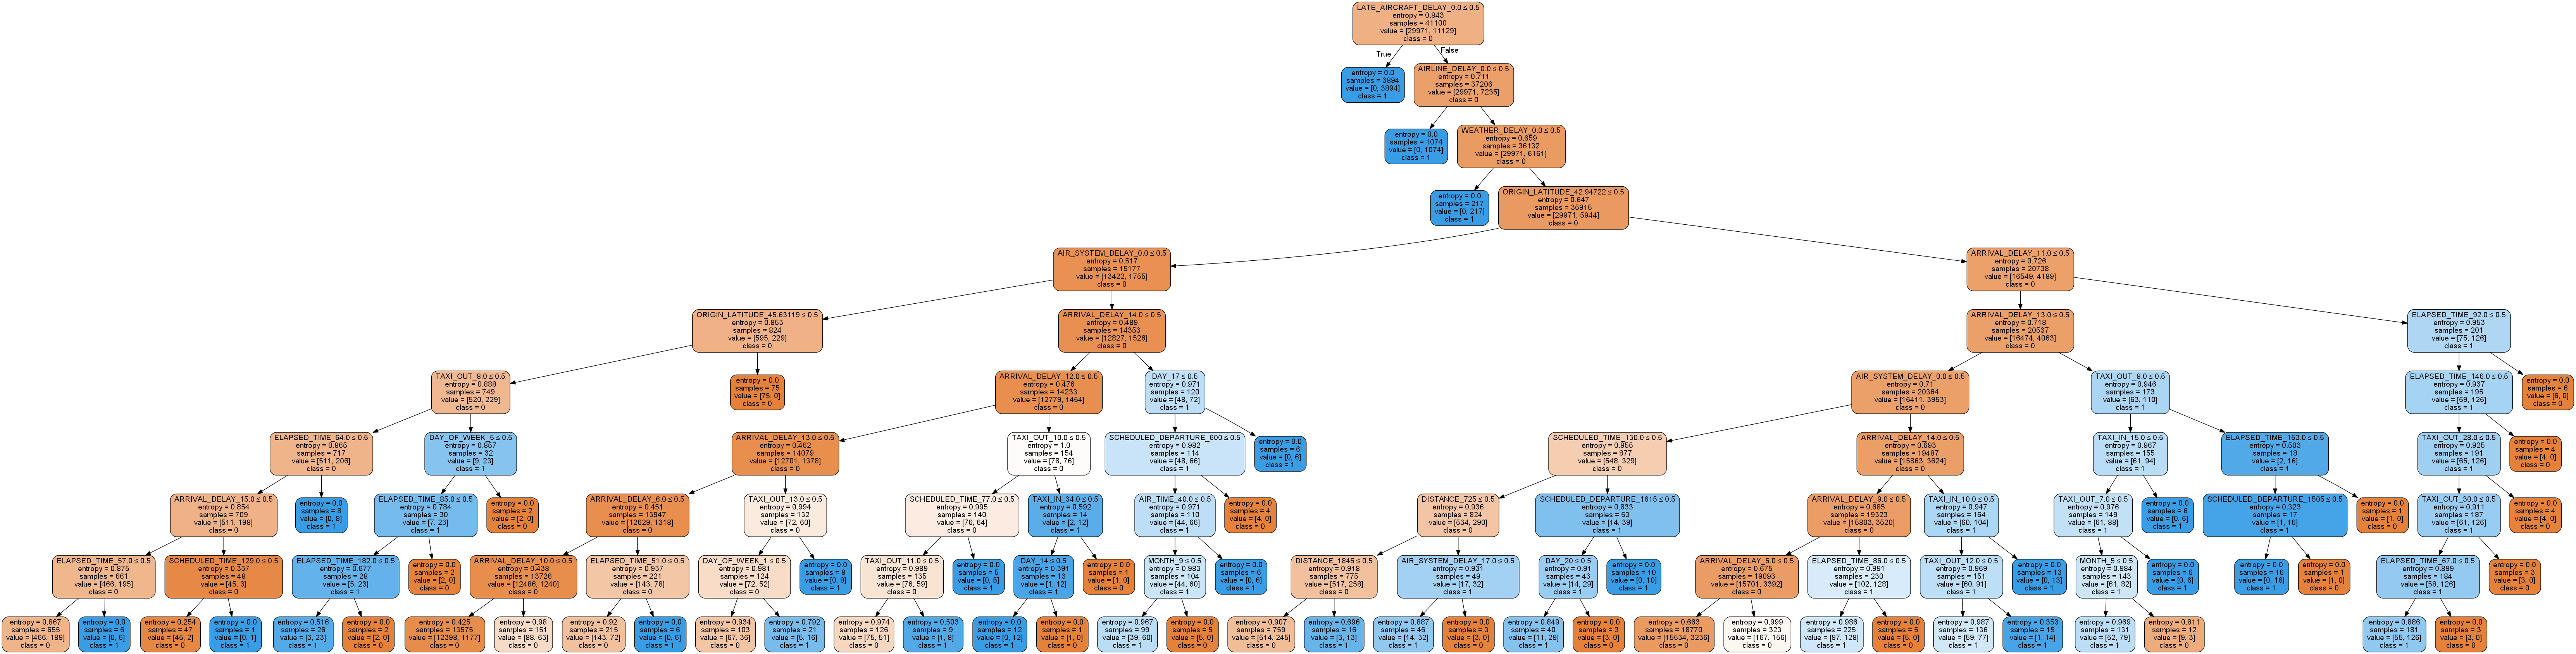

In [158]:
# Create DOT data
dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=ohe_df.columns,  
                           class_names=np.unique(y).astype('str'), 
                           filled=True, rounded=True, special_characters=True)

# Draw graph
graph = graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())


In [159]:
X_test_ohe = ohe.transform(X_test)
y_preds = clf.predict(X_test_ohe)

print('Accuracy: ', accuracy_score(y_test, y_preds))

ValueError: Found unknown categories [521, 522, 818, 951, 1101, 1108, 1159, 1317, 1403, 1524, 1613, 1617, 1639, 1923, 2020, 2037, 2150] in column 3 during transform

In [162]:
# from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

X = dff.drop('DELAYED_TARGET', axis=1)
y = dff['DELAYED_TARGET']

tree_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [163]:
from sklearn.tree import export_graphviz

export_graphviz(tree_clf, 
                feature_names=features,
                class_names=y, 
                rounded=True, 
                filled=True)

TypeError: can only concatenate str (not "numpy.int32") to str

### Next Thing: Random Forests

In [200]:
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [201]:
data = pd.get_dummies(dfff)
data.head()

,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_DEPARTURE,TAXI_OUT,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,DESTINATION_LATITUDE,DESTINATION_LONGITUDE,DELAYED_TARGET
0,7,1,3,1605,11.0,260.0,254.0,231.0,1694,1805.0,12.0,1825,1817.0,-8.0,0,0,0.0,0.0,0.0,0.0,0.0,42.94722,-87.89658,47.44898,-122.30931,0
1,7,2,4,1605,14.0,260.0,258.0,234.0,1694,1808.0,10.0,1825,1818.0,-7.0,0,0,0.0,0.0,0.0,0.0,0.0,42.94722,-87.89658,47.44898,-122.30931,0
2,7,3,5,1605,17.0,260.0,284.0,257.0,1694,1839.0,10.0,1825,1849.0,24.0,0,0,24.0,0.0,0.0,0.0,0.0,42.94722,-87.89658,47.44898,-122.30931,0
3,7,4,6,1605,12.0,260.0,247.0,224.0,1694,1754.0,11.0,1825,1805.0,-20.0,0,0,0.0,0.0,0.0,0.0,0.0,42.94722,-87.89658,47.44898,-122.30931,0
4,7,5,7,1605,11.0,260.0,238.0,221.0,1694,1752.0,6.0,1825,1758.0,-27.0,0,0,0.0,0.0,0.0,0.0,0.0,42.94722,-87.89658,47.44898,-122.30931,0


In [202]:
# Split the outcome and predictor variables
target = dff['DELAYED_TARGET']
salaries = dff.drop("DELAYED_TARGET", axis=1)

In [203]:
salaries.dtypes

MONTH                      int64
DAY                        int64
DAY_OF_WEEK                int64
SCHEDULED_DEPARTURE        int64
TAXI_OUT                 float64
SCHEDULED_TIME           float64
ELAPSED_TIME             float64
AIR_TIME                 float64
DISTANCE                   int64
WHEELS_ON                float64
TAXI_IN                  float64
SCHEDULED_ARRIVAL          int64
ARRIVAL_TIME             float64
ARRIVAL_DELAY            float64
DIVERTED                   int64
CANCELLED                  int64
AIR_SYSTEM_DELAY         float64
SECURITY_DELAY           float64
AIRLINE_DELAY            float64
LATE_AIRCRAFT_DELAY      float64
WEATHER_DELAY            float64
ORIGIN_LATITUDE          float64
ORIGIN_LONGITUDE         float64
DESTINATION_LATITUDE     float64
DESTINATION_LONGITUDE    float64
dtype: object

In [210]:
# Create dummy variables
data = pd.get_dummies(salaries)
data.head()

,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_DEPARTURE,TAXI_OUT,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,DESTINATION_LATITUDE,DESTINATION_LONGITUDE
0,7,1,3,1605,11.0,260.0,254.0,231.0,1694,1805.0,12.0,1825,1817.0,-8.0,0,0,0.0,0.0,0.0,0.0,0.0,42.94722,-87.89658,47.44898,-122.30931
1,7,2,4,1605,14.0,260.0,258.0,234.0,1694,1808.0,10.0,1825,1818.0,-7.0,0,0,0.0,0.0,0.0,0.0,0.0,42.94722,-87.89658,47.44898,-122.30931
2,7,3,5,1605,17.0,260.0,284.0,257.0,1694,1839.0,10.0,1825,1849.0,24.0,0,0,24.0,0.0,0.0,0.0,0.0,42.94722,-87.89658,47.44898,-122.30931
3,7,4,6,1605,12.0,260.0,247.0,224.0,1694,1754.0,11.0,1825,1805.0,-20.0,0,0,0.0,0.0,0.0,0.0,0.0,42.94722,-87.89658,47.44898,-122.30931
4,7,5,7,1605,11.0,260.0,238.0,221.0,1694,1752.0,6.0,1825,1758.0,-27.0,0,0,0.0,0.0,0.0,0.0,0.0,42.94722,-87.89658,47.44898,-122.30931


In [211]:
data_train, data_test, target_train, target_test = train_test_split(data, target, 
                                                                    test_size = 0.25, random_state=123)

In [212]:
# Instantiate and fit a DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(criterion='gini', max_depth=5) 
tree_clf.fit(data_train, target_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [213]:
# Feature importance
tree_clf.feature_importances_

array([0.        , 0.        , 0.        , 0.01553047, 0.0535833 ,
       0.00933728, 0.00746062, 0.01390791, 0.        , 0.00187609,
       0.03888994, 0.        , 0.00305698, 0.71116293, 0.        ,
       0.        , 0.        , 0.        , 0.05118655, 0.08139703,
       0.0126109 , 0.        , 0.        , 0.        , 0.        ])

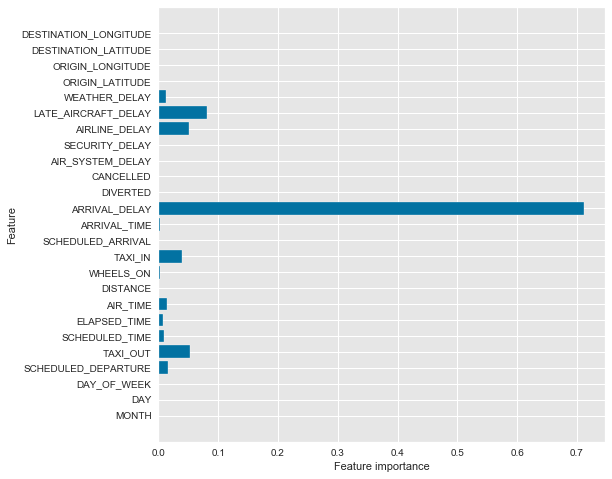

In [214]:
def plot_feature_importances(model):
    n_features = data_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), data_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(tree_clf)